## Long story short: GLU activation works comparable to ReLU

Comparable in terms of model accuracy and model parameters count

In [8]:
import time
from typing import Optional, Tuple, List, Dict
import colorsys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from enum import Enum

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.__version__

'1.13.1+cu117'

In [11]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [12]:

class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str = 'cuda') -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=2048,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [13]:
class Mode(Enum):
    RELU = 1
    GLU = 2
    SOFTMAX = 3
    SOFTMAX_4HEADS = 4

    @staticmethod
    def modes() -> Dict[str, 'Mode']:
        return {
            'relu': Mode.RELU,
            'glu': Mode.GLU,
            'softmax': Mode.SOFTMAX,
            'softmax4heads': Mode.SOFTMAX_4HEADS,
        }

class SoftmaxMultihead(nn.Module):
    def __init__(self, heads_count: int = 1):
        super().__init__()
        self.heads_count: int = 1
        self.softmax: nn.Module = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.size()
        assert c % (2 * self.heads_count) == 0
        mid = c // 2
        assert mid // self.heads_count > 1
        mask = x[:, :mid].reshape(b, mid // self.heads_count, self.heads_count, h, w)
        mask = self.softmax(mask).reshape(b, mid, h, w)
        return mask * x[:, mid:]

class MyConvModel(nn.Module):
    def __init__(self, channels: int, mode: Mode):
        super().__init__()

        self.mode = mode

        c = channels
        self.layers = nn.Sequential(
            *self.conv(1, c, kernel_size=3),  # 28 - 26
            *self.conv(c, c, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            *self.conv(c, c * 2, kernel_size=3),  # 12 - 10
            *self.conv(c * 2, c * 2, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            *self.conv(c * 2, c * 4, kernel_size=3),  # 4 - 2
            *self.conv(c * 4, c * 4, kernel_size=2),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size) -> List[nn.Module]:
        if self.mode == Mode.RELU:
            return [
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.1)
            ]
        
        if self.mode == Mode.GLU:
            activation = nn.GLU(dim=1)
        elif self.mode == Mode.SOFTMAX:
            activation = SoftmaxMultihead(1)        
        elif self.mode == Mode.SOFTMAX_4HEADS:
            activation = SoftmaxMultihead(4)
        else:
            raise ValueError(f"unexpected mode {self.mode}")
            
        return [
            nn.Conv2d(in_ch, out_ch * 2, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch * 2),
            activation,
        ]
        
    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [14]:
def run_networks(repeats: int = 1) -> Dict[str, List[Tuple[int, int]]]:
    results = {}

    for name, mode in Mode.modes().items():        
        if name not in results:
            results[name] = []
        for i in range(repeats):
            print(f'start train network with {name}, repeat {i}')
            models = [MyConvModel(n, mode) for n in [8, 12, 16, 24, 32]]

            for pair in TrainHelper.train_models(models):
                results[name].append(pair)

    return results

results = run_networks()

start train network with relu, repeat 0
best accuracy = 0.9931, parameters = 13362, training time = 92.92904043197632
best accuracy = 0.994, parameters = 29590, training time = 90.55582857131958
best accuracy = 0.9947, parameters = 52186, training time = 91.12156701087952
best accuracy = 0.995, parameters = 116482, training time = 91.11689066886902
best accuracy = 0.9951, parameters = 206250, training time = 92.60616874694824
start train network with glu, repeat 0
best accuracy = 0.9943, parameters = 26394, training time = 91.27785134315491
best accuracy = 0.9945, parameters = 58690, training time = 90.30192184448242
best accuracy = 0.995, parameters = 103722, training time = 90.52655029296875
best accuracy = 0.9956, parameters = 231994, training time = 90.17642951011658
best accuracy = 0.9955, parameters = 411210, training time = 89.19211459159851
start train network with softmax, repeat 0
best accuracy = 0.9911, parameters = 26394, training time = 87.88686919212341
best accuracy = 0.

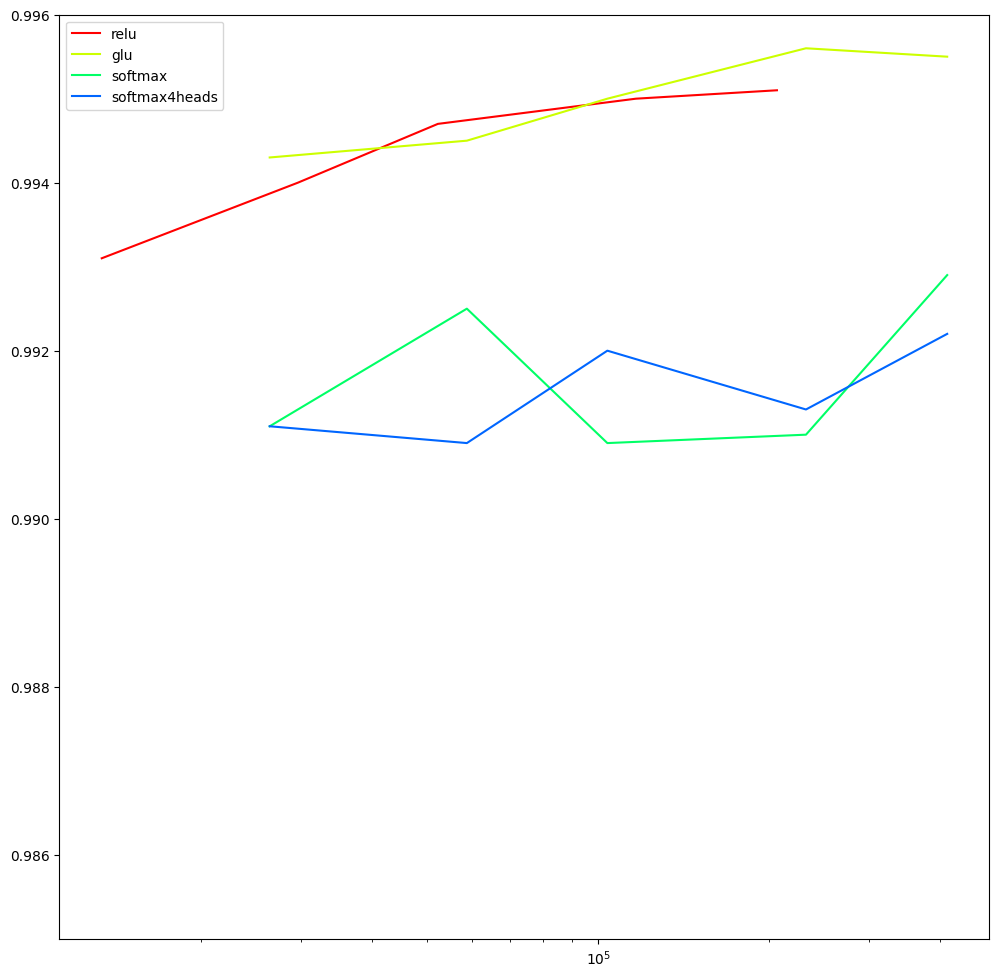

In [15]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.985, 0.996)

for i, (name, r) in enumerate(results.items()):
    params_counts = [p[0] for p in r]
    accuracies = [p[1] for p in r]

    color = colorsys.hsv_to_rgb(i * 0.2, 1.0, 1.0)
    ax.plot(params_counts, accuracies, c=color, label=name)

ax.legend()
plt.show()

start train network with relu, repeat 0
best accuracy = 0.9922, parameters = 13362, training time = 86.05151176452637
best accuracy = 0.9934, parameters = 29590, training time = 85.90862202644348
best accuracy = 0.994, parameters = 52186, training time = 85.54017210006714
best accuracy = 0.9943, parameters = 116482, training time = 85.90509128570557
best accuracy = 0.9955, parameters = 206250, training time = 85.92326664924622
start train network with glu, repeat 0
best accuracy = 0.9943, parameters = 26394, training time = 85.7241621017456
best accuracy = 0.9943, parameters = 58690, training time = 85.51422309875488
best accuracy = 0.995, parameters = 103722, training time = 85.51282095909119
best accuracy = 0.9958, parameters = 231994, training time = 86.47019743919373
best accuracy = 0.9957, parameters = 411210, training time = 86.99437952041626
start train network with softmax, repeat 0
best accuracy = 0.9933, parameters = 26394, training time = 86.29445815086365
best accuracy = 0.

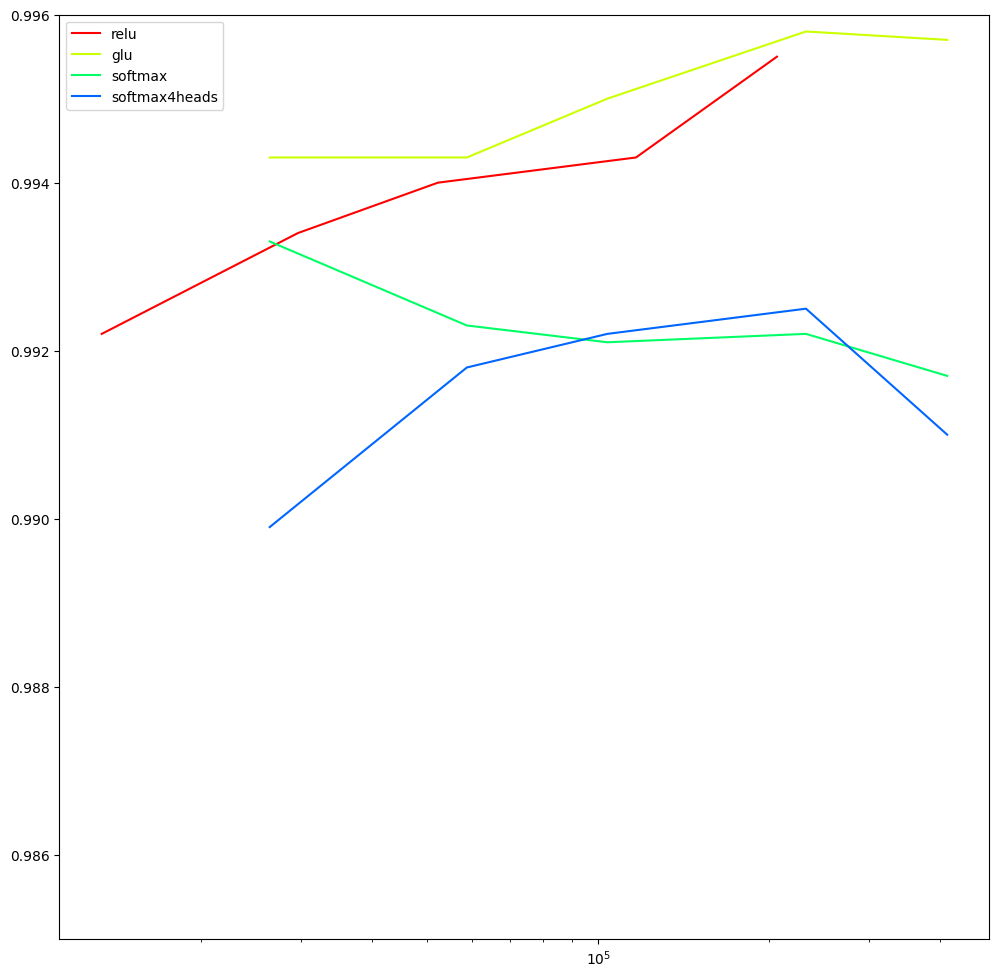

In [16]:
class MyConvModelNoBN(nn.Module):
    def __init__(self, channels: int, mode: Mode):
        super().__init__()

        self.mode = mode

        c = channels
        self.layers = nn.Sequential(
            *self.conv(1, c, kernel_size=3),  # 28 - 26
            *self.conv(c, c, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            *self.conv(c, c * 2, kernel_size=3),  # 12 - 10
            *self.conv(c * 2, c * 2, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            *self.conv(c * 2, c * 4, kernel_size=3),  # 4 - 2
            *self.conv(c * 4, c * 4, kernel_size=2),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size) -> List[nn.Module]:
        if self.mode == Mode.RELU:
            return [
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=True),
                nn.LeakyReLU(0.1)
            ]

        if self.mode == Mode.GLU:
            activation = nn.GLU(dim=1)
        elif self.mode == Mode.SOFTMAX:
            activation = SoftmaxMultihead(1)
        elif self.mode == Mode.SOFTMAX_4HEADS:
            activation = SoftmaxMultihead(4)
        else:
            raise ValueError(f"unexpected mode {self.mode}")

        return [
            nn.Conv2d(in_ch, out_ch * 2, kernel_size=kernel_size, padding='valid', bias=True),
            activation,
        ]

    def forward(self, x: torch.Tensor):
        return self.layers(x)


def run_networks_no_bn(repeats: int = 1) -> Dict[str, List[Tuple[int, int]]]:
    results = {}

    for name, mode in Mode.modes().items():
        if name not in results:
            results[name] = []
        for i in range(repeats):
            print(f'start train network with {name}, repeat {i}')
            models = [MyConvModelNoBN(n, mode) for n in [8, 12, 16, 24, 32]]

            for pair in TrainHelper.train_models(models):
                results[name].append(pair)

    return results


results_no_bn = run_networks()

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.985, 0.996)

for i, (name, r) in enumerate(results_no_bn.items()):
    params_counts = [p[0] for p in r]
    accuracies = [p[1] for p in r]

    color = colorsys.hsv_to_rgb(i * 0.2, 1.0, 1.0)
    ax.plot(params_counts, accuracies, c=color, label=name)

ax.legend()
plt.show()